# SPECFEM++ with Ivy's custom 1D bathymetry profiles




In the following notebook, we will show how to use the SPECFEM++ software with
custom 1D bathymetry profiles. We will use the example of the 1D bathymetry
profile at Mermaid `P0009` for the M6.5 earthquake in Indonesia at depth 529km.

The example first gets the event provided an approximate location, time_frame
and magnitude. It'll then get the Mermaid location based on coordinate

In [1]:
%load_ext autoreload
%autoreload 2

import obspy
from specfempp.examples_utilities.get_gcmt import get_gcmt

In [2]:

import obspy
from specfempp.examples_utilities.get_gcmt import get_gcmt


## Downloading event information

Before we start looking at the bathymetry we need to find the event


In [3]:
# Event location
approx_event_lat =  -7.310
approx_event_lon =  +119.750
approx_event_mag = 6.5

# Event time span
t1 = obspy.UTCDateTime("2018-08-17T00:00:00")
t2 = obspy.UTCDateTime("2018-08-18T00:00:00")


In [4]:

# Using SPUD to download the QuakeML catalog file and return event
gcmt = get_gcmt(t1, t2, 
                minlat=approx_event_lat-1, maxlat=approx_event_lat+1, 
                minlon=approx_event_lon-1, maxlon=approx_event_lon+ 1,
                minmag=approx_event_mag-0.1, maxmag=approx_event_mag+0.1)[0]

# Get some information about the event
event_lat = gcmt.origins[0].latitude
event_lon = gcmt.origins[0].longitude
event_depth = gcmt.origins[0].depth
event_time = gcmt.origins[0].time
event_mag = gcmt.magnitudes[0].mag


Getting event 18000041


### Event information:

In [5]:
print( f"Event Lat:   {event_lat}")
print( f"Event Lon:   {event_lon}")
print( f"Event Depth: {event_depth}")
print( f"Event Time:  {event_time}")
print( f"Event Mag:   {event_mag}")

Event Lat:   -7.37
Event Lon:   119.8
Event Depth: 529000.0
Event Time:  2018-08-17T15:35:01.900000Z
Event Mag:   6.5


## Downloading station information



Now that we have gathered the event information, we can collect the metadata
for the MERMAID hydrophone (Network code : `MH`) and the station code `P0009`.

First, let's look at the the info we can get from `obspy`.

In [6]:
# Mermaid ID always 5 (see https://www.fdsn.org/networks/detail/MH/)
mermaid_network_code = "MH"
mermaid_station_code = "P0009"


from obspy.clients.fdsn import Client
client = Client("IRIS")
inv = client.get_stations(network=mermaid_network_code, starttime=t1, endtime=t2, level="response")
inv.select(station=mermaid_station_code)

Inventory created at 2025-03-27T06:42:51.479100Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-08-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			MH
		Stations (1):
			MH.P0009 (MERMAIDHydrophone)
		Channels (1):
			MH.P0009.00.BDH

This is sadly not enough information to get the exact location of the station.
Since the inventory/`station.xml` file does not contain contiuous records of the
location of the station. We will have to use the Princeton MERMAID database to
get the exact location of the station.



### Getting the exact location of the station

In [7]:
import specfempp.examples_utilities.mermaid as mermaid

# Download the mermaid metadata from Geoweb SOM
mermaid_metadata = mermaid.download_position(mermaid_station_code)

# Get the location of the mermaid at the time of the event
station_lon_mermaid, station_lat_mermaid, station_depth_mermaid = mermaid.get_location(mermaid_metadata, event_time)
print(f"Station Location: {station_lat_mermaid}, {station_lon_mermaid}, {station_depth_mermaid}")

Station Location: -12.002379954886987, -168.3781642375485, 1500.0


This is the interpolated location of `P0009` from the Princeton MERMAID database.
However, Joel Simon has computed a more accurate location for the station with
additional locations of the station. So, for the purpose of this example, we will
use the location provided by Joel Simon that has been given to me by Ivy.


### Comparing to the locations Ivy used in the paper (from Joel Simon)

In [8]:

# Information provided by Ivy to reproduce the results of the paper.
station_lat= -12.0025 
station_lon= -168.3766
station_depth=1518
station_bathymetry=4128

# Compare the location of the station with the one provided by Ivy
print(f"               {'Ivy':>10s} <-> {'Interp.':>10s}")
print(f"Station Lat:   {station_lat:>10.4f} <-> {station_lat_mermaid:>10.4f}")
print(f"Station Lon:   {station_lon:>10.4f} <-> {station_lon_mermaid:>10.4f}")
print(f"Station Depth: {station_depth:>10.4f} <-> {station_depth_mermaid:>10.4f}")



                      Ivy <->    Interp.
Station Lat:     -12.0025 <->   -12.0024
Station Lon:    -168.3766 <->  -168.3782
Station Depth:  1518.0000 <->  1500.0000


Now that we have both station and event information, we can plot the geometry
using `pygmt`.

In [9]:
import specfempp.examples_utilities.mapping as mapping


### Event and station geometry using PyGMT

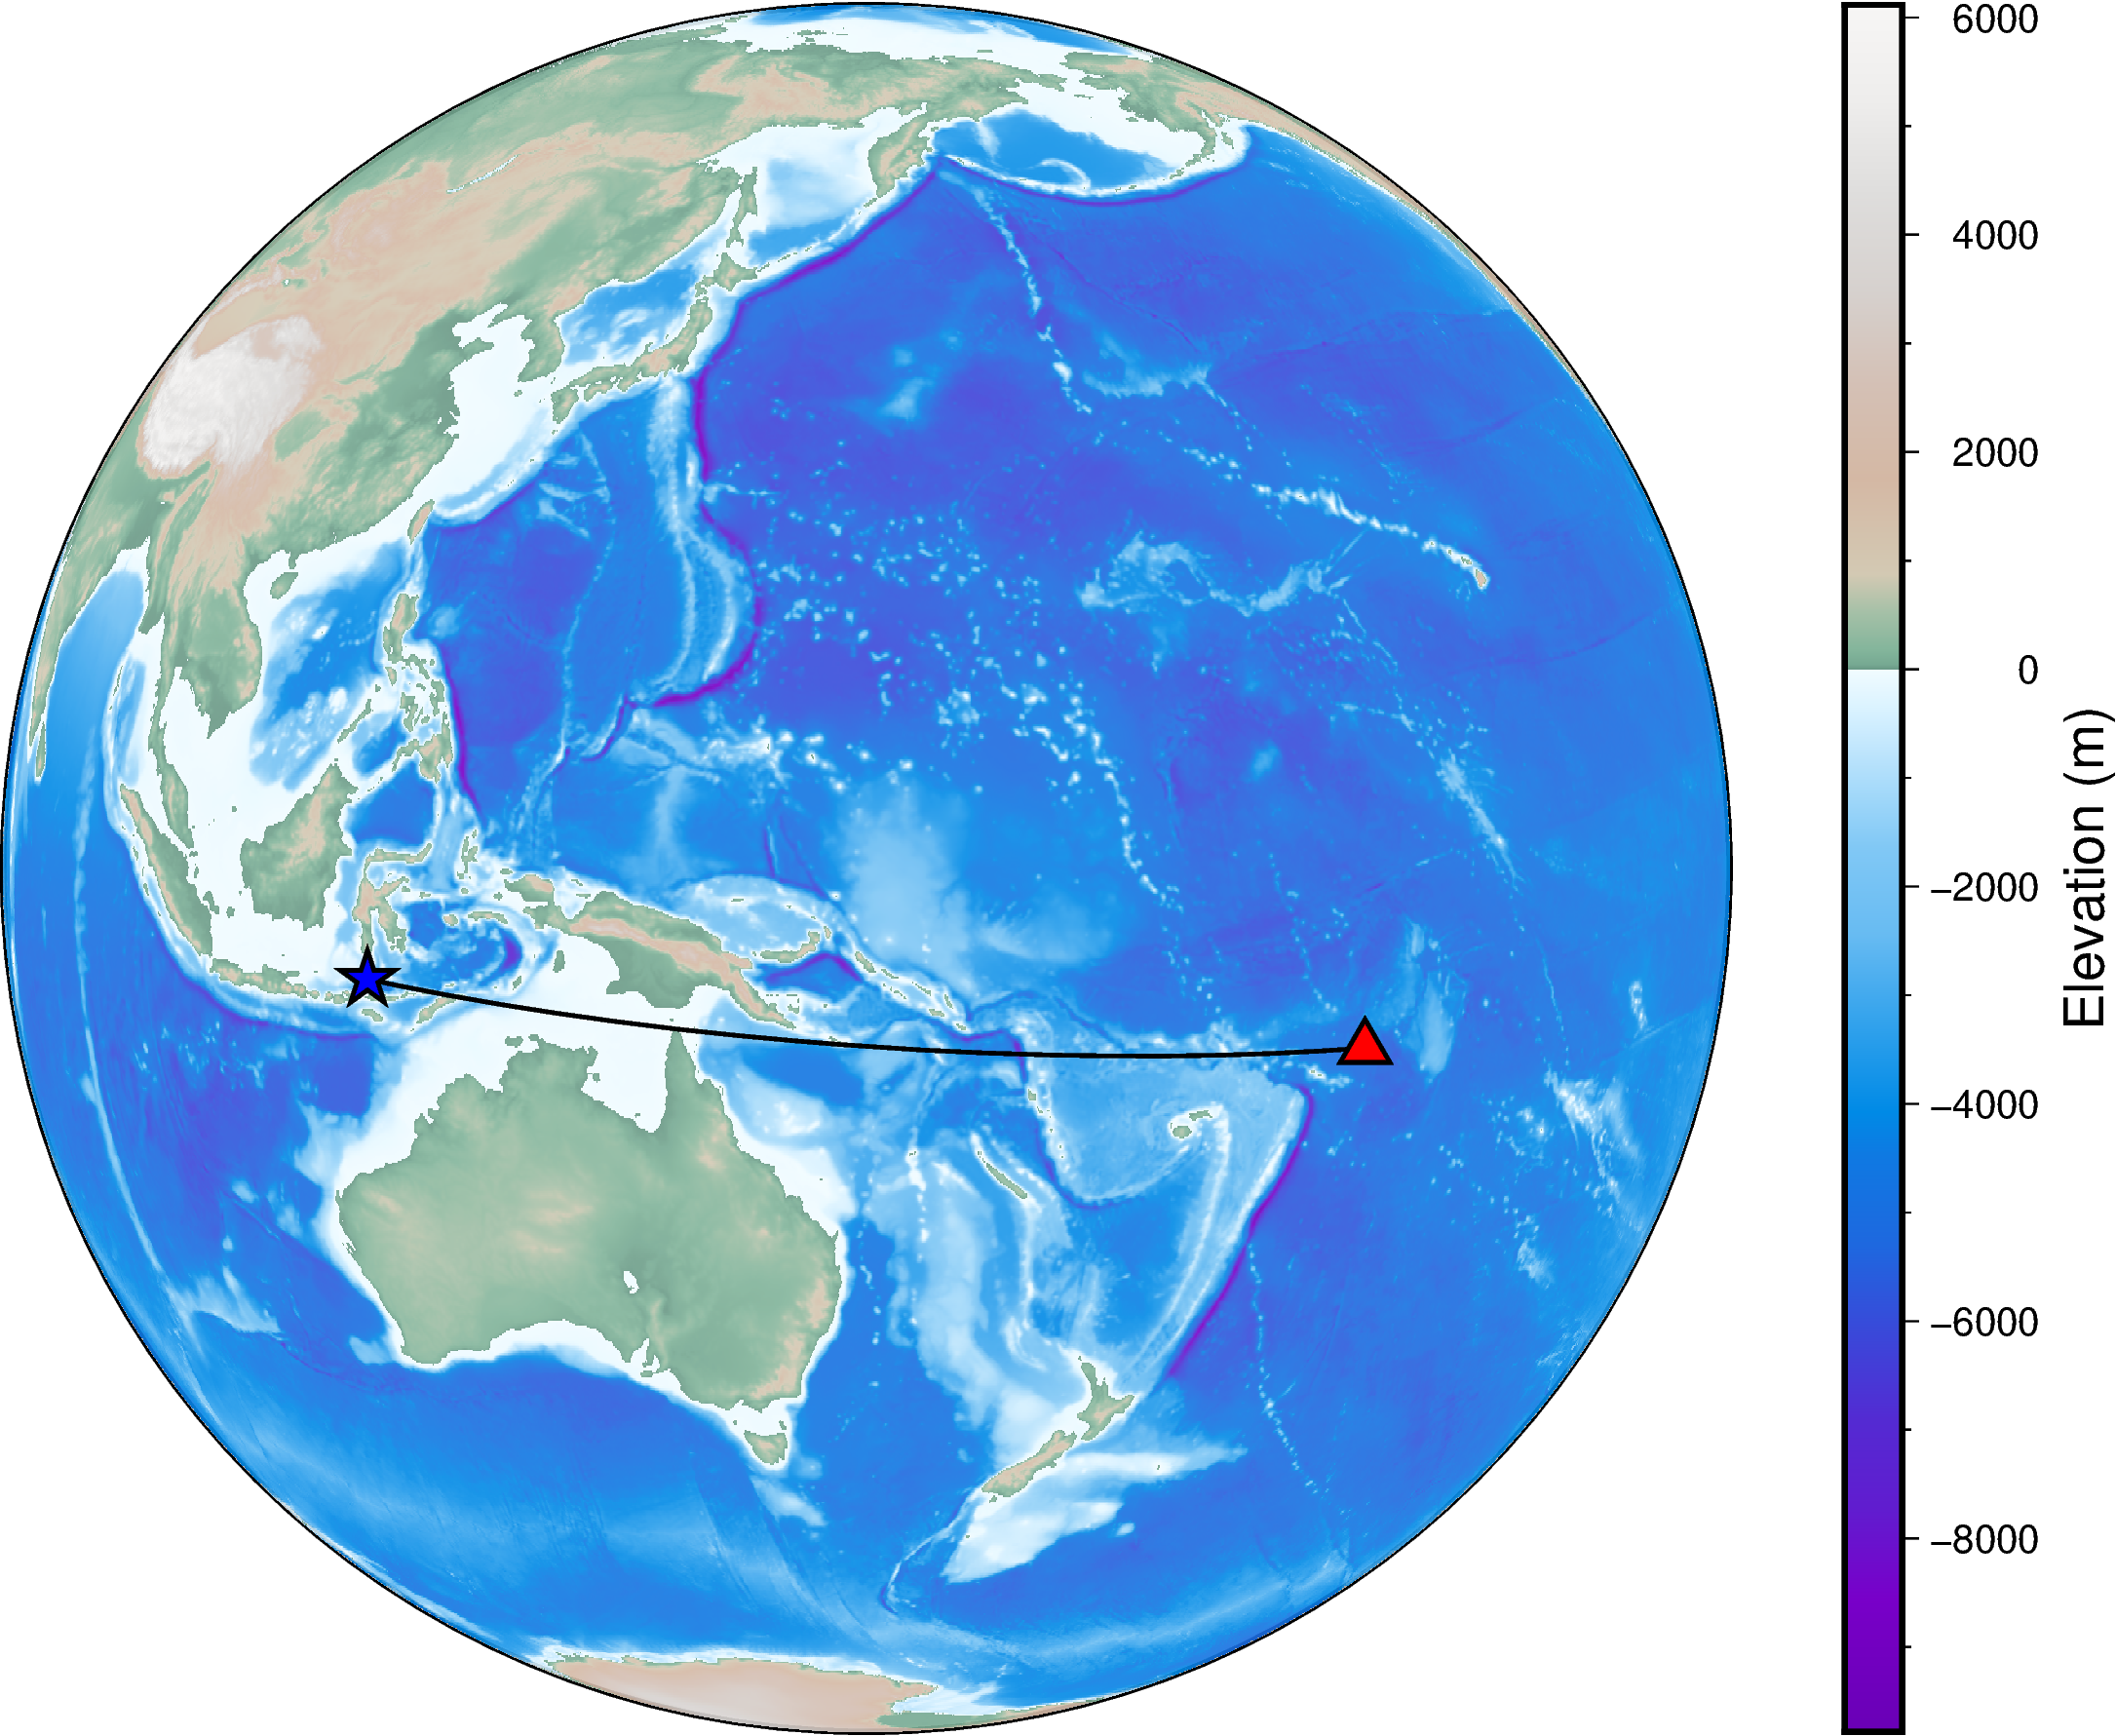

In [10]:
fig = mapping.plot_station_event_geometry(event_lat, event_lon, station_lat, station_lon)
fig.show()

Now, to the bathymetry around the station. We will first get map extents around
the MERMAID and the event, the complete Mermaid track, and the local extent
around the MERMAID.

The local extent (`line_extent`) is computed using the +/- 10 km around the 
station along the backazimuth of the event.

The `mermaid.get_extent` function is getting the min/max latitude and longitude
of the Mermaid track.

The `mapping.get_extent` function is getting the min/max latitude and longitude
of the event and station location.

Finally, `mapping.fix_extent` is taking the found extent and expanind it by a
buffer of 5% and fixing the short end to create a 2 to 1 aspect ratio.


In [11]:

import specfempp.examples_utilities.mermaid as mermaid
import matplotlib.dates as mdates

# Get the extent of the mermaid track
mermaid_extent = mermaid.get_extent(mermaid_metadata)

# Fix the extent for ok map aspect ratio
mermaid_extent = mapping.fix_extent(mermaid_extent)

# Get the extent of the event and the station
event_station_extent = mapping.get_extent(event_lat, event_lon, station_lat, station_lon)

# Fix the extent for ok map aspect ratio
event_station_extent = mapping.fix_extent(event_station_extent)


The next step is defining the line around the Mermaid along which we want to 
extract the bathymetry. As defined in Ivy's paper the line is selected along the
backazimuth of the event and 10 km on either side of the station.

### Getting the line along which to interpolate the bathymetry

In [12]:
dist_in_m, az, baz = obspy.geodetics.gps2dist_azimuth(event_lat, event_lon, station_lat, station_lon)

# Define with 
width = 20000
npts = 501

# Get the line around the station
line_offset, line_latitudes, line_longitudes = \
    mapping.get_line(station_lat, station_lon,width, npts, baz)


In [13]:
# Get the line_extent
line_extent = mapping.get_extent(line_latitudes[0], line_longitudes[0],
                                  line_latitudes[-1], line_longitudes[-1])

# Fix the extent for ok map aspect ratio
line_extent = mapping.fix_extent(line_extent, fraction=0.2)

In [14]:
print(f"Line Extent: {line_extent}")
print(f"Line Longitudes: {line_longitudes[0]}, {line_longitudes[-1]}")
print(f"Line Latitudes: {line_latitudes[0]}, {line_latitudes[-1]}")

Line Extent: [-168.44074152726733, -168.3124594696831, -12.03456676415771, -11.970425735365588]
Line Longitudes: -168.33078547790942, -168.422415519041
Line Latitudes: -11.999545162551588, -12.005447336971711


Now, before we map everything, let's extract the bathymetry around the mermaid
track for reference, and locally around the station to interpolate the
bathymetry along the line.

### Extracting bathymetry around the station

In [15]:
import specfempp.examples_utilities.gebco as gebco

# Download the bathymetry from GEBCO
gebco.download()

# Extract bathymetry for the mermaid extent
mermaid_bathymetry = gebco.get_bathymetry(mermaid_extent, split=False)

# Local bathymetry around the station
local_bathymetry = gebco.get_bathymetry(line_extent, split=False)

Bathymetry data already exists. Skipping download.


Now that we the bathymetry we can interpolate the line bathymetry using the
`scipy.interpolate.griddata` function.


### Interpolating the bathymetry along the line

In [16]:
line_offset, line_bathymetry, line_latitudes, line_longitudes = \
    gebco.bathymetryprofile(
        width, npts, [station_lon, station_lat], baz, 
        input_lons=local_bathymetry['longitudes'], 
        input_lats=local_bathymetry['latitudes'], 
        input_bathy=local_bathymetry['elevation'])


Now that the bathymetry is interpolated, we can plot a summary map of the
bathymetry around the station and the event along with the Mermaid track.

### Plotting the bathymetry around the station and event

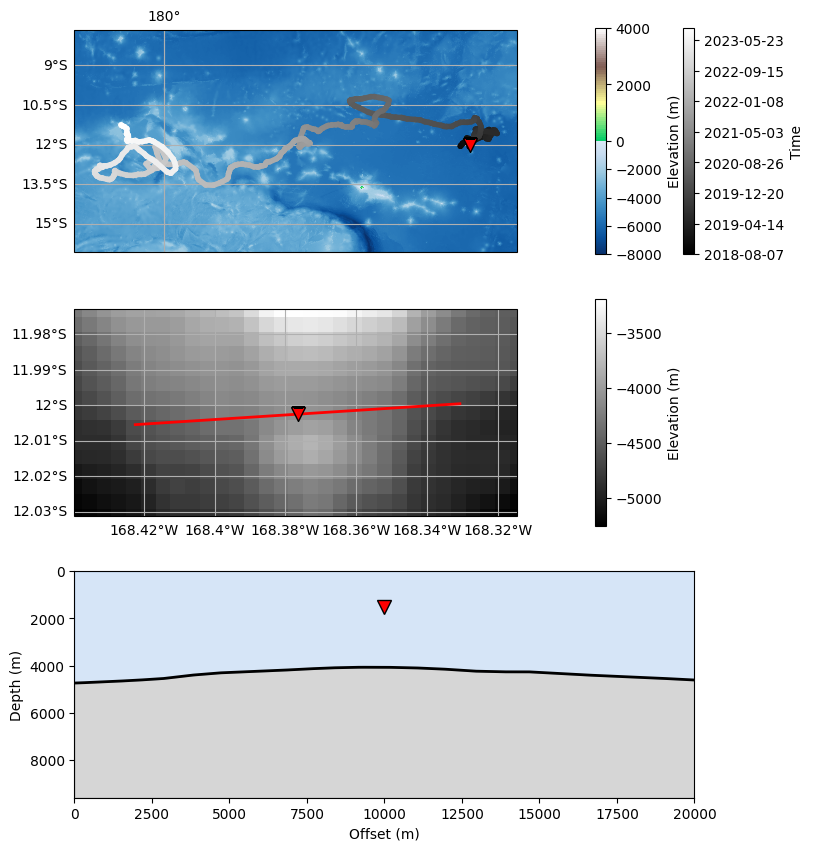

In [17]:
gebco.plot_summary(station_lat, station_lon, event_lat, event_lon,
                   mermaid_metadata,
                   mermaid_bathymetry, local_bathymetry, 
                   line_offset, line_bathymetry, 
                   line_latitudes, line_longitudes)


The final step before writing the necessary files and running the simulation is 
to compute the incidence angle of the plane wave impinging on the domain.


### Computing the incidence angle

In [18]:
import obspy.taup

# Use ak135 model
model = obspy.taup.TauPyModel(model="ak135")

# Get the travel times
arrivals = model.get_ray_paths(source_depth_in_km=event_depth/1000,
                               distance_in_degree=dist_in_m/1000/111.195,
                               phase_list=["P"])

# Get the incidence angle
incidence_angle = arrivals[0].incident_angle

print(f"Incidence Angle: {incidence_angle:.2f} degrees")

Incidence Angle: 17.88 degrees


## Running the simulation with SPECFEM++



Now that we have the bathymetry and the incidence angle, we can run the
simulation with SPECFEM++ since we are able to generate the mesh file, the
topography file, and create the sources to be generated.

The next step is to create the mesh parameter file by first reading a base
`Par_file` and updating the necessary parameters to adjust for size and
resolution of the mesh.

### Update Parameter file and Topography file

In [19]:
from specfempp.utilities import get_par_file, write_par_file

# Get the base par file
par_dict = get_par_file("Base_Par_file", verbose=False, savecomments=True)

par_dict["receiversets"]["nrec"], \
par_dict["receiversets"]["zdeb"], \
par_dict["receiversets"]["zfin"]

([1, 1], [8082.0, 5472.0], [8082.0, 5472.0])

In [20]:
# Update the par file # make sure that bathymetry values are positive here!
gebco.update_par_file_extent(par_dict, line_offset[-1], 9600, 9600+line_bathymetry, verbose=True)

# Write the par file
write_par_file(par_dict, "Par_file", write_comments=True)

nx: 250, ny: 120, nlower: 54, nupper: 66


Next, we need to write the topography file, which is a simple ASCII file with
the bathymetry values at each point in the mesh.


In [21]:
gebco.write_topography_file("topography_file.dat", line_offset[-1], 9600, 9600+line_bathymetry, line_offset)

Finally, we can run the mesher.

In [22]:
from subprocess import call
from os import makedirs

### Running the mesher

In [23]:
# Create the output directory for the database files.
makedirs("OUTPUT_FILES/results", exist_ok=True)
call("xmeshfem2D -p Par_file", shell=True)


 **********************************************
 *** Specfem 2-D Mesher - serial version    ***
 **********************************************

 Running Git version of the code corresponding to f8c66778e3bcff99be726113a1aca338255ed87e
 dating 2023-03-21 19:54:51 +0100

 Reading the parameter file...

 Title of the simulation: fluid-solid-bathymetry

 Receiver lines:
   Nb of line sets =            2

   Materials:
   Nb of solid, fluid or porous materials =            2

 --------
 Material #           1  isotropic
 rho,cp,cs   =    2500.0000000000000        3400.0000000000000        1963.0000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is solid
 --------
 Material #           2  isotropic
 rho,cp,cs   =    1020.0000000000000        1500.0000000000000        0.0000000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is fluid
 --------


 Mesh from internal meshing:

 Reading interface data from

0

### Setup the file to run the simulation.

In [24]:
from specfempp import Config

config = Config({
    "databases": {
        "mesh-database": "OUTPUT_FILES/database.bin"
    },
    "header": {
        "description": "Material systems : Elastic domain (1), Acoustic domain (1)\nInterfaces : Acoustic-elastic interface (1) (orientation horizontal with acoustic domain on top)\nSources : Moment-tensor (234)\nBoundary conditions : Neumann BCs on all edges\n",
        "title": "fluid-solid-bathymetry"
    },
    "receivers": {
        "angle": 0.0,
        "nstep_between_samples": 10,
        "seismogram-type": [
            "pressure"
        ],
        "stations": "OUTPUT_FILES/STATIONS"
    },
    "run-setup": {
        "number-of-processors": 1,
        "number-of-runs": 1
    },
    "simulation-setup": {
        "quadrature": {
            "quadrature-type": "GLL4"
        },
        "simulation-mode": {
            "forward": {
                "writer": {
                    "seismogram": {
                        "directory": "OUTPUT_FILES/results",
                        "format": "ascii"
                    }
                }
            }
        },
        "solver": {
            "time-marching": {
                "time-scheme": {
                    "dt": 0.002,
                    "nstep": 5000,
                    "type": "Newmark"
                },
                "type-of-simulation": "forward"
            }
        }
    },
    "sources": "line_sources.yaml"
})

We use the `create_sources` function, which relies on the P wave velocity and
the incidence angle. to compute the sequentially firing points sources that form
a line source that is observed as a plane wave at the station.


### Create the source file

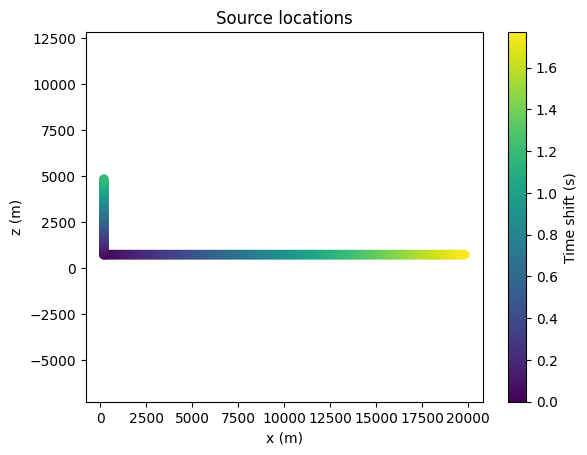

In [25]:
from specfempp.examples_utilities import sources

# Create source file
source_dict = sources.create_sources(incidence_angle, 3400, bathymetry_in_m=-line_bathymetry,
                                     bathymetry_offset_in_m=line_offset)

# plot the source
sources.plot_sources(source_dict)

# Set the source in the config
config.set_par("sources", source_dict)


Now we add the receivers to the simulation.

### Add the receivers

In [26]:
receiver_list = list()
receiver1 = dict(network="AA", station="S0003", x=10000.0, z=8082.0)
receiver2 = dict(network="AA", station="S0004", x=10000.0, z=5472.0)
receiver_list.extend([receiver1, receiver2])

config.set_par("receivers.stations", receiver_list)


In [27]:
config.save_par("./test_config.yaml")

### Run the simulation

In [28]:
from specfempp import Config, execute 
execute(config)

              SPECFEM2D SIMULATION

Title : fluid-solid-bathymetry
Discription: Material systems : Elastic domain (1), Acoustic domain (1)
Interfaces : Acoustic-elastic interface (1) (orientation horizontal with acoustic domain on top)
Sources : Moment-tensor (234)
Boundary conditions : Neumann BCs on all edges

Simulation start time: Thu Mar 27 02:43:37 2025
------------------------------------------------

 Quadrature in X-dimension 
------------------------------
- GLL
    alpha = 0
    beta = 0
    Number of GLL points = 5

 Quadrature in Z-dimension 
------------------------------
- GLL
    alpha = 0
    beta = 0
    Number of GLL points = 5

Material systems:
------------------------------
Number of material systems = 2

Material systems:
------------------------------
Number of material systems = 2


- Elastic Material : 
    Properties:
      density : 2500
      cs : 1963
      cp : 3400
      kappa : 1.92666e+10
      mu : 9.63342e+09
      Qkappa : 9999
      Qmu : 9999
    

In [29]:
import glob
import os
import numpy as np
import obspy
import matplotlib.pyplot as plt

def get_traces(directory):
    traces = []
    files = glob.glob(directory + "/*.sem*")
    ## iterate over all seismograms
    for filename in files:
        station_name = os.path.splitext(filename)[0]
        station_name = station_name.split("/")[-1]
        trace = np.loadtxt(filename, delimiter=" ")
        starttime = trace[0, 0]
        dt = trace[1, 0] - trace[0, 0]
        traces.append(
            obspy.Trace(
                trace[:, 1],
                {"network": station_name, "starttime": starttime, "delta": dt},
            )
        )

    stream = obspy.Stream(traces)

    return stream



### Get traces

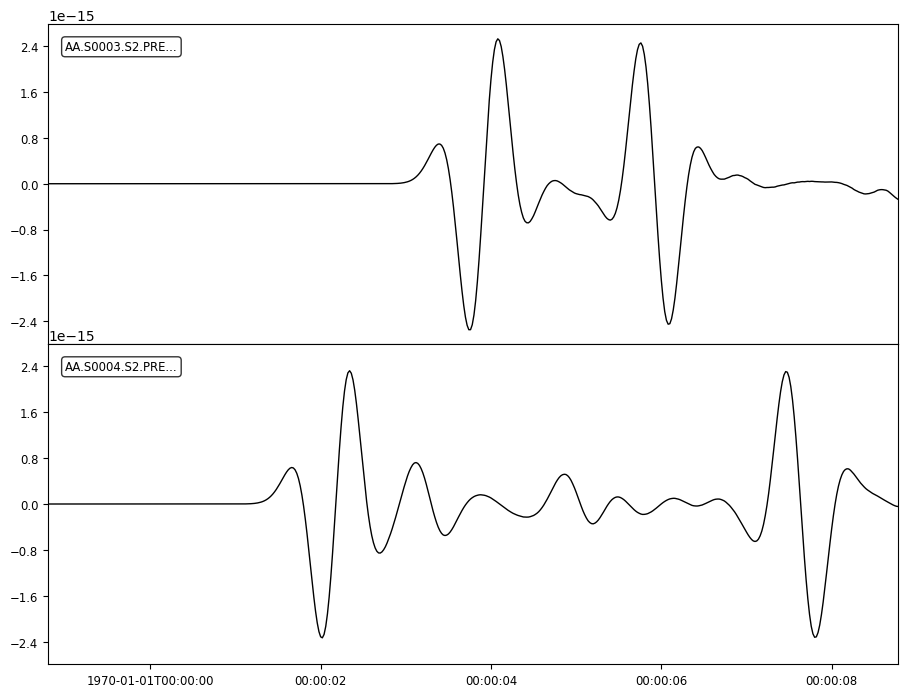

In [30]:
stream = get_traces("OUTPUT_FILES/results")
fig = plt.figure(figsize=(10, 8))
stream.plot(fig=fig)
plt.show()

### Snapshots of the simulation

To add some visualization we can add the displace section to the config file and
rerun the simulation.

In [31]:
Ddisplay = {"directory": "OUTPUT_FILES/results",
            "field": "displacement",
            "format": "PNG",
            "simulation-field": "forward",
            "time-interval": 200}
config.set_par('simulation-setup.simulation-mode.forward.writer.display', Ddisplay)

execute(config)

              SPECFEM2D SIMULATION

Title : fluid-solid-bathymetry
Discription: Material systems : Elastic domain (1), Acoustic domain (1)
Interfaces : Acoustic-elastic interface (1) (orientation horizontal with acoustic domain on top)
Sources : Moment-tensor (234)
Boundary conditions : Neumann BCs on all edges

Simulation start time: Thu Mar 27 02:45:35 2025
------------------------------------------------

 Quadrature in X-dimension 
------------------------------
- GLL
    alpha = 0
    beta = 0
    Number of GLL points = 5

 Quadrature in Z-dimension 
------------------------------
- GLL
    alpha = 0
    beta = 0
    Number of GLL points = 5

Material systems:
------------------------------
Number of material systems = 2

Material systems:
------------------------------
Number of material systems = 2


- Elastic Material : 
    Properties:
      density : 2500
      cs : 1963
      cp : 3400
      kappa : 1.92666e+10
      mu : 9.63342e+09
      Qkappa : 9999
      Qmu : 9999
    

2025-03-27 02:45:40.203 ( 174.727s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:45:40.268 ( 174.793s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 0 steps of 5000 steps
Progress : executed 10 steps of 5000 steps
Progress : executed 20 steps of 5000 steps
Progress : executed 30 steps of 5000 steps
Progress : executed 40 steps of 5000 steps
Progress : executed 50 steps of 5000 steps
Progress : executed 60 steps of 5000 steps
Progress : executed 70 steps of 5000 steps
Progress : executed 80 steps of 5000 steps
Progress : executed 90 steps of 5000 steps
Progress : executed 100 steps of 5000 steps
Progress : executed 110 steps of 5000 steps
Progress : executed 120 steps of 5000 steps
Progress : executed 130 steps of 5000 steps
Progress : executed 140 steps of 5000 steps
Progress : executed 150 steps of 5000 steps
Progress : executed 160 steps of 5000 steps
Progress : executed 170 steps of 5000 steps
Progress : executed 180 steps of 5000 steps
Progress : executed 190 steps of 5000 steps


2025-03-27 02:45:45.834 ( 180.358s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:45:45.899 ( 180.424s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 200 steps of 5000 steps
Progress : executed 210 steps of 5000 steps
Progress : executed 220 steps of 5000 steps
Progress : executed 230 steps of 5000 steps
Progress : executed 240 steps of 5000 steps
Progress : executed 250 steps of 5000 steps
Progress : executed 260 steps of 5000 steps
Progress : executed 270 steps of 5000 steps
Progress : executed 280 steps of 5000 steps
Progress : executed 290 steps of 5000 steps
Progress : executed 300 steps of 5000 steps
Progress : executed 310 steps of 5000 steps
Progress : executed 320 steps of 5000 steps
Progress : executed 330 steps of 5000 steps
Progress : executed 340 steps of 5000 steps
Progress : executed 350 steps of 5000 steps
Progress : executed 360 steps of 5000 steps
Progress : executed 370 steps of 5000 steps
Progress : executed 380 steps of 5000 steps
Progress : executed 390 steps of 5000 steps


2025-03-27 02:45:51.047 ( 185.572s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:45:51.111 ( 185.636s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 400 steps of 5000 steps
Progress : executed 410 steps of 5000 steps
Progress : executed 420 steps of 5000 steps
Progress : executed 430 steps of 5000 steps
Progress : executed 440 steps of 5000 steps
Progress : executed 450 steps of 5000 steps
Progress : executed 460 steps of 5000 steps
Progress : executed 470 steps of 5000 steps
Progress : executed 480 steps of 5000 steps
Progress : executed 490 steps of 5000 steps
Progress : executed 500 steps of 5000 steps
Progress : executed 510 steps of 5000 steps
Progress : executed 520 steps of 5000 steps
Progress : executed 530 steps of 5000 steps
Progress : executed 540 steps of 5000 steps
Progress : executed 550 steps of 5000 steps
Progress : executed 560 steps of 5000 steps
Progress : executed 570 steps of 5000 steps
Progress : executed 580 steps of 5000 steps
Progress : executed 590 steps of 5000 steps


2025-03-27 02:45:56.223 ( 190.748s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:45:56.287 ( 190.812s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 600 steps of 5000 steps
Progress : executed 610 steps of 5000 steps
Progress : executed 620 steps of 5000 steps
Progress : executed 630 steps of 5000 steps
Progress : executed 640 steps of 5000 steps
Progress : executed 650 steps of 5000 steps
Progress : executed 660 steps of 5000 steps
Progress : executed 670 steps of 5000 steps
Progress : executed 680 steps of 5000 steps
Progress : executed 690 steps of 5000 steps
Progress : executed 700 steps of 5000 steps
Progress : executed 710 steps of 5000 steps
Progress : executed 720 steps of 5000 steps
Progress : executed 730 steps of 5000 steps
Progress : executed 740 steps of 5000 steps
Progress : executed 750 steps of 5000 steps
Progress : executed 760 steps of 5000 steps
Progress : executed 770 steps of 5000 steps
Progress : executed 780 steps of 5000 steps
Progress : executed 790 steps of 5000 steps


2025-03-27 02:46:01.413 ( 195.938s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:01.478 ( 196.003s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 800 steps of 5000 steps
Progress : executed 810 steps of 5000 steps
Progress : executed 820 steps of 5000 steps
Progress : executed 830 steps of 5000 steps
Progress : executed 840 steps of 5000 steps
Progress : executed 850 steps of 5000 steps
Progress : executed 860 steps of 5000 steps
Progress : executed 870 steps of 5000 steps
Progress : executed 880 steps of 5000 steps
Progress : executed 890 steps of 5000 steps
Progress : executed 900 steps of 5000 steps
Progress : executed 910 steps of 5000 steps
Progress : executed 920 steps of 5000 steps
Progress : executed 930 steps of 5000 steps
Progress : executed 940 steps of 5000 steps
Progress : executed 950 steps of 5000 steps
Progress : executed 960 steps of 5000 steps
Progress : executed 970 steps of 5000 steps
Progress : executed 980 steps of 5000 steps
Progress : executed 990 steps of 5000 steps


2025-03-27 02:46:06.635 ( 201.160s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:06.700 ( 201.225s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 1000 steps of 5000 steps
Progress : executed 1010 steps of 5000 steps
Progress : executed 1020 steps of 5000 steps
Progress : executed 1030 steps of 5000 steps
Progress : executed 1040 steps of 5000 steps
Progress : executed 1050 steps of 5000 steps
Progress : executed 1060 steps of 5000 steps
Progress : executed 1070 steps of 5000 steps
Progress : executed 1080 steps of 5000 steps
Progress : executed 1090 steps of 5000 steps
Progress : executed 1100 steps of 5000 steps
Progress : executed 1110 steps of 5000 steps
Progress : executed 1120 steps of 5000 steps
Progress : executed 1130 steps of 5000 steps
Progress : executed 1140 steps of 5000 steps
Progress : executed 1150 steps of 5000 steps
Progress : executed 1160 steps of 5000 steps
Progress : executed 1170 steps of 5000 steps
Progress : executed 1180 steps of 5000 steps
Progress : executed 1190 steps of 5000 steps


2025-03-27 02:46:11.824 ( 206.349s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:11.890 ( 206.415s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 1200 steps of 5000 steps
Progress : executed 1210 steps of 5000 steps
Progress : executed 1220 steps of 5000 steps
Progress : executed 1230 steps of 5000 steps
Progress : executed 1240 steps of 5000 steps
Progress : executed 1250 steps of 5000 steps
Progress : executed 1260 steps of 5000 steps
Progress : executed 1270 steps of 5000 steps
Progress : executed 1280 steps of 5000 steps
Progress : executed 1290 steps of 5000 steps
Progress : executed 1300 steps of 5000 steps
Progress : executed 1310 steps of 5000 steps
Progress : executed 1320 steps of 5000 steps
Progress : executed 1330 steps of 5000 steps
Progress : executed 1340 steps of 5000 steps
Progress : executed 1350 steps of 5000 steps
Progress : executed 1360 steps of 5000 steps
Progress : executed 1370 steps of 5000 steps
Progress : executed 1380 steps of 5000 steps
Progress : executed 1390 steps of 5000 steps


2025-03-27 02:46:17.084 ( 211.608s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:17.148 ( 211.673s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 1400 steps of 5000 steps
Progress : executed 1410 steps of 5000 steps
Progress : executed 1420 steps of 5000 steps
Progress : executed 1430 steps of 5000 steps
Progress : executed 1440 steps of 5000 steps
Progress : executed 1450 steps of 5000 steps
Progress : executed 1460 steps of 5000 steps
Progress : executed 1470 steps of 5000 steps
Progress : executed 1480 steps of 5000 steps
Progress : executed 1490 steps of 5000 steps
Progress : executed 1500 steps of 5000 steps
Progress : executed 1510 steps of 5000 steps
Progress : executed 1520 steps of 5000 steps
Progress : executed 1530 steps of 5000 steps
Progress : executed 1540 steps of 5000 steps
Progress : executed 1550 steps of 5000 steps
Progress : executed 1560 steps of 5000 steps
Progress : executed 1570 steps of 5000 steps
Progress : executed 1580 steps of 5000 steps
Progress : executed 1590 steps of 5000 steps


2025-03-27 02:46:22.310 ( 216.834s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:22.374 ( 216.899s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 1600 steps of 5000 steps
Progress : executed 1610 steps of 5000 steps
Progress : executed 1620 steps of 5000 steps
Progress : executed 1630 steps of 5000 steps
Progress : executed 1640 steps of 5000 steps
Progress : executed 1650 steps of 5000 steps
Progress : executed 1660 steps of 5000 steps
Progress : executed 1670 steps of 5000 steps
Progress : executed 1680 steps of 5000 steps
Progress : executed 1690 steps of 5000 steps
Progress : executed 1700 steps of 5000 steps
Progress : executed 1710 steps of 5000 steps
Progress : executed 1720 steps of 5000 steps
Progress : executed 1730 steps of 5000 steps
Progress : executed 1740 steps of 5000 steps
Progress : executed 1750 steps of 5000 steps
Progress : executed 1760 steps of 5000 steps
Progress : executed 1770 steps of 5000 steps
Progress : executed 1780 steps of 5000 steps
Progress : executed 1790 steps of 5000 steps


2025-03-27 02:46:27.529 ( 222.054s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:27.594 ( 222.119s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 1800 steps of 5000 steps
Progress : executed 1810 steps of 5000 steps
Progress : executed 1820 steps of 5000 steps
Progress : executed 1830 steps of 5000 steps
Progress : executed 1840 steps of 5000 steps
Progress : executed 1850 steps of 5000 steps
Progress : executed 1860 steps of 5000 steps
Progress : executed 1870 steps of 5000 steps
Progress : executed 1880 steps of 5000 steps
Progress : executed 1890 steps of 5000 steps
Progress : executed 1900 steps of 5000 steps
Progress : executed 1910 steps of 5000 steps
Progress : executed 1920 steps of 5000 steps
Progress : executed 1930 steps of 5000 steps
Progress : executed 1940 steps of 5000 steps
Progress : executed 1950 steps of 5000 steps
Progress : executed 1960 steps of 5000 steps
Progress : executed 1970 steps of 5000 steps
Progress : executed 1980 steps of 5000 steps
Progress : executed 1990 steps of 5000 steps


2025-03-27 02:46:32.726 ( 227.251s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:32.790 ( 227.315s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 2000 steps of 5000 steps
Progress : executed 2010 steps of 5000 steps
Progress : executed 2020 steps of 5000 steps
Progress : executed 2030 steps of 5000 steps
Progress : executed 2040 steps of 5000 steps
Progress : executed 2050 steps of 5000 steps
Progress : executed 2060 steps of 5000 steps
Progress : executed 2070 steps of 5000 steps
Progress : executed 2080 steps of 5000 steps
Progress : executed 2090 steps of 5000 steps
Progress : executed 2100 steps of 5000 steps
Progress : executed 2110 steps of 5000 steps
Progress : executed 2120 steps of 5000 steps
Progress : executed 2130 steps of 5000 steps
Progress : executed 2140 steps of 5000 steps
Progress : executed 2150 steps of 5000 steps
Progress : executed 2160 steps of 5000 steps
Progress : executed 2170 steps of 5000 steps
Progress : executed 2180 steps of 5000 steps
Progress : executed 2190 steps of 5000 steps


2025-03-27 02:46:37.916 ( 232.441s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:37.981 ( 232.505s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 2200 steps of 5000 steps
Progress : executed 2210 steps of 5000 steps
Progress : executed 2220 steps of 5000 steps
Progress : executed 2230 steps of 5000 steps
Progress : executed 2240 steps of 5000 steps
Progress : executed 2250 steps of 5000 steps
Progress : executed 2260 steps of 5000 steps
Progress : executed 2270 steps of 5000 steps
Progress : executed 2280 steps of 5000 steps
Progress : executed 2290 steps of 5000 steps
Progress : executed 2300 steps of 5000 steps
Progress : executed 2310 steps of 5000 steps
Progress : executed 2320 steps of 5000 steps
Progress : executed 2330 steps of 5000 steps
Progress : executed 2340 steps of 5000 steps
Progress : executed 2350 steps of 5000 steps
Progress : executed 2360 steps of 5000 steps
Progress : executed 2370 steps of 5000 steps
Progress : executed 2380 steps of 5000 steps
Progress : executed 2390 steps of 5000 steps


2025-03-27 02:46:43.082 ( 237.607s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:43.146 ( 237.671s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 2400 steps of 5000 steps
Progress : executed 2410 steps of 5000 steps
Progress : executed 2420 steps of 5000 steps
Progress : executed 2430 steps of 5000 steps
Progress : executed 2440 steps of 5000 steps
Progress : executed 2450 steps of 5000 steps
Progress : executed 2460 steps of 5000 steps
Progress : executed 2470 steps of 5000 steps
Progress : executed 2480 steps of 5000 steps
Progress : executed 2490 steps of 5000 steps
Progress : executed 2500 steps of 5000 steps
Progress : executed 2510 steps of 5000 steps
Progress : executed 2520 steps of 5000 steps
Progress : executed 2530 steps of 5000 steps
Progress : executed 2540 steps of 5000 steps
Progress : executed 2550 steps of 5000 steps
Progress : executed 2560 steps of 5000 steps
Progress : executed 2570 steps of 5000 steps
Progress : executed 2580 steps of 5000 steps
Progress : executed 2590 steps of 5000 steps


2025-03-27 02:46:48.248 ( 242.772s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:48.312 ( 242.836s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 2600 steps of 5000 steps
Progress : executed 2610 steps of 5000 steps
Progress : executed 2620 steps of 5000 steps
Progress : executed 2630 steps of 5000 steps
Progress : executed 2640 steps of 5000 steps
Progress : executed 2650 steps of 5000 steps
Progress : executed 2660 steps of 5000 steps
Progress : executed 2670 steps of 5000 steps
Progress : executed 2680 steps of 5000 steps
Progress : executed 2690 steps of 5000 steps
Progress : executed 2700 steps of 5000 steps
Progress : executed 2710 steps of 5000 steps
Progress : executed 2720 steps of 5000 steps
Progress : executed 2730 steps of 5000 steps
Progress : executed 2740 steps of 5000 steps
Progress : executed 2750 steps of 5000 steps
Progress : executed 2760 steps of 5000 steps
Progress : executed 2770 steps of 5000 steps
Progress : executed 2780 steps of 5000 steps
Progress : executed 2790 steps of 5000 steps


2025-03-27 02:46:53.454 ( 247.978s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:53.518 ( 248.043s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 2800 steps of 5000 steps
Progress : executed 2810 steps of 5000 steps
Progress : executed 2820 steps of 5000 steps
Progress : executed 2830 steps of 5000 steps
Progress : executed 2840 steps of 5000 steps
Progress : executed 2850 steps of 5000 steps
Progress : executed 2860 steps of 5000 steps
Progress : executed 2870 steps of 5000 steps
Progress : executed 2880 steps of 5000 steps
Progress : executed 2890 steps of 5000 steps
Progress : executed 2900 steps of 5000 steps
Progress : executed 2910 steps of 5000 steps
Progress : executed 2920 steps of 5000 steps
Progress : executed 2930 steps of 5000 steps
Progress : executed 2940 steps of 5000 steps
Progress : executed 2950 steps of 5000 steps
Progress : executed 2960 steps of 5000 steps
Progress : executed 2970 steps of 5000 steps
Progress : executed 2980 steps of 5000 steps
Progress : executed 2990 steps of 5000 steps


2025-03-27 02:46:58.636 ( 253.161s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:46:58.700 ( 253.225s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 3000 steps of 5000 steps
Progress : executed 3010 steps of 5000 steps
Progress : executed 3020 steps of 5000 steps
Progress : executed 3030 steps of 5000 steps
Progress : executed 3040 steps of 5000 steps
Progress : executed 3050 steps of 5000 steps
Progress : executed 3060 steps of 5000 steps
Progress : executed 3070 steps of 5000 steps
Progress : executed 3080 steps of 5000 steps
Progress : executed 3090 steps of 5000 steps
Progress : executed 3100 steps of 5000 steps
Progress : executed 3110 steps of 5000 steps
Progress : executed 3120 steps of 5000 steps
Progress : executed 3130 steps of 5000 steps
Progress : executed 3140 steps of 5000 steps
Progress : executed 3150 steps of 5000 steps
Progress : executed 3160 steps of 5000 steps
Progress : executed 3170 steps of 5000 steps
Progress : executed 3180 steps of 5000 steps
Progress : executed 3190 steps of 5000 steps


2025-03-27 02:47:03.796 ( 258.320s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:03.861 ( 258.385s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 3200 steps of 5000 steps
Progress : executed 3210 steps of 5000 steps
Progress : executed 3220 steps of 5000 steps
Progress : executed 3230 steps of 5000 steps
Progress : executed 3240 steps of 5000 steps
Progress : executed 3250 steps of 5000 steps
Progress : executed 3260 steps of 5000 steps
Progress : executed 3270 steps of 5000 steps
Progress : executed 3280 steps of 5000 steps
Progress : executed 3290 steps of 5000 steps
Progress : executed 3300 steps of 5000 steps
Progress : executed 3310 steps of 5000 steps
Progress : executed 3320 steps of 5000 steps
Progress : executed 3330 steps of 5000 steps
Progress : executed 3340 steps of 5000 steps
Progress : executed 3350 steps of 5000 steps
Progress : executed 3360 steps of 5000 steps
Progress : executed 3370 steps of 5000 steps
Progress : executed 3380 steps of 5000 steps
Progress : executed 3390 steps of 5000 steps


2025-03-27 02:47:08.958 ( 263.482s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:09.022 ( 263.546s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 3400 steps of 5000 steps
Progress : executed 3410 steps of 5000 steps
Progress : executed 3420 steps of 5000 steps
Progress : executed 3430 steps of 5000 steps
Progress : executed 3440 steps of 5000 steps
Progress : executed 3450 steps of 5000 steps
Progress : executed 3460 steps of 5000 steps
Progress : executed 3470 steps of 5000 steps
Progress : executed 3480 steps of 5000 steps
Progress : executed 3490 steps of 5000 steps
Progress : executed 3500 steps of 5000 steps
Progress : executed 3510 steps of 5000 steps
Progress : executed 3520 steps of 5000 steps
Progress : executed 3530 steps of 5000 steps
Progress : executed 3540 steps of 5000 steps
Progress : executed 3550 steps of 5000 steps
Progress : executed 3560 steps of 5000 steps
Progress : executed 3570 steps of 5000 steps
Progress : executed 3580 steps of 5000 steps
Progress : executed 3590 steps of 5000 steps


2025-03-27 02:47:14.122 ( 268.646s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:14.187 ( 268.711s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 3600 steps of 5000 steps
Progress : executed 3610 steps of 5000 steps
Progress : executed 3620 steps of 5000 steps
Progress : executed 3630 steps of 5000 steps
Progress : executed 3640 steps of 5000 steps
Progress : executed 3650 steps of 5000 steps
Progress : executed 3660 steps of 5000 steps
Progress : executed 3670 steps of 5000 steps
Progress : executed 3680 steps of 5000 steps
Progress : executed 3690 steps of 5000 steps
Progress : executed 3700 steps of 5000 steps
Progress : executed 3710 steps of 5000 steps
Progress : executed 3720 steps of 5000 steps
Progress : executed 3730 steps of 5000 steps
Progress : executed 3740 steps of 5000 steps
Progress : executed 3750 steps of 5000 steps
Progress : executed 3760 steps of 5000 steps
Progress : executed 3770 steps of 5000 steps
Progress : executed 3780 steps of 5000 steps
Progress : executed 3790 steps of 5000 steps


2025-03-27 02:47:19.308 ( 273.832s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:19.372 ( 273.896s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 3800 steps of 5000 steps
Progress : executed 3810 steps of 5000 steps
Progress : executed 3820 steps of 5000 steps
Progress : executed 3830 steps of 5000 steps
Progress : executed 3840 steps of 5000 steps
Progress : executed 3850 steps of 5000 steps
Progress : executed 3860 steps of 5000 steps
Progress : executed 3870 steps of 5000 steps
Progress : executed 3880 steps of 5000 steps
Progress : executed 3890 steps of 5000 steps
Progress : executed 3900 steps of 5000 steps
Progress : executed 3910 steps of 5000 steps
Progress : executed 3920 steps of 5000 steps
Progress : executed 3930 steps of 5000 steps
Progress : executed 3940 steps of 5000 steps
Progress : executed 3950 steps of 5000 steps
Progress : executed 3960 steps of 5000 steps
Progress : executed 3970 steps of 5000 steps
Progress : executed 3980 steps of 5000 steps
Progress : executed 3990 steps of 5000 steps


2025-03-27 02:47:24.489 ( 279.013s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:24.554 ( 279.078s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 4000 steps of 5000 steps
Progress : executed 4010 steps of 5000 steps
Progress : executed 4020 steps of 5000 steps
Progress : executed 4030 steps of 5000 steps
Progress : executed 4040 steps of 5000 steps
Progress : executed 4050 steps of 5000 steps
Progress : executed 4060 steps of 5000 steps
Progress : executed 4070 steps of 5000 steps
Progress : executed 4080 steps of 5000 steps
Progress : executed 4090 steps of 5000 steps
Progress : executed 4100 steps of 5000 steps
Progress : executed 4110 steps of 5000 steps
Progress : executed 4120 steps of 5000 steps
Progress : executed 4130 steps of 5000 steps
Progress : executed 4140 steps of 5000 steps
Progress : executed 4150 steps of 5000 steps
Progress : executed 4160 steps of 5000 steps
Progress : executed 4170 steps of 5000 steps
Progress : executed 4180 steps of 5000 steps
Progress : executed 4190 steps of 5000 steps


2025-03-27 02:47:29.679 ( 284.203s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:29.744 ( 284.268s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 4200 steps of 5000 steps
Progress : executed 4210 steps of 5000 steps
Progress : executed 4220 steps of 5000 steps
Progress : executed 4230 steps of 5000 steps
Progress : executed 4240 steps of 5000 steps
Progress : executed 4250 steps of 5000 steps
Progress : executed 4260 steps of 5000 steps
Progress : executed 4270 steps of 5000 steps
Progress : executed 4280 steps of 5000 steps
Progress : executed 4290 steps of 5000 steps
Progress : executed 4300 steps of 5000 steps
Progress : executed 4310 steps of 5000 steps
Progress : executed 4320 steps of 5000 steps
Progress : executed 4330 steps of 5000 steps
Progress : executed 4340 steps of 5000 steps
Progress : executed 4350 steps of 5000 steps
Progress : executed 4360 steps of 5000 steps
Progress : executed 4370 steps of 5000 steps
Progress : executed 4380 steps of 5000 steps
Progress : executed 4390 steps of 5000 steps


2025-03-27 02:47:34.885 ( 289.409s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:34.950 ( 289.474s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 4400 steps of 5000 steps
Progress : executed 4410 steps of 5000 steps
Progress : executed 4420 steps of 5000 steps
Progress : executed 4430 steps of 5000 steps
Progress : executed 4440 steps of 5000 steps
Progress : executed 4450 steps of 5000 steps
Progress : executed 4460 steps of 5000 steps
Progress : executed 4470 steps of 5000 steps
Progress : executed 4480 steps of 5000 steps
Progress : executed 4490 steps of 5000 steps
Progress : executed 4500 steps of 5000 steps
Progress : executed 4510 steps of 5000 steps
Progress : executed 4520 steps of 5000 steps
Progress : executed 4530 steps of 5000 steps
Progress : executed 4540 steps of 5000 steps
Progress : executed 4550 steps of 5000 steps
Progress : executed 4560 steps of 5000 steps
Progress : executed 4570 steps of 5000 steps
Progress : executed 4580 steps of 5000 steps
Progress : executed 4590 steps of 5000 steps


2025-03-27 02:47:40.102 ( 294.626s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:40.166 ( 294.690s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 4600 steps of 5000 steps
Progress : executed 4610 steps of 5000 steps
Progress : executed 4620 steps of 5000 steps
Progress : executed 4630 steps of 5000 steps
Progress : executed 4640 steps of 5000 steps
Progress : executed 4650 steps of 5000 steps
Progress : executed 4660 steps of 5000 steps
Progress : executed 4670 steps of 5000 steps
Progress : executed 4680 steps of 5000 steps
Progress : executed 4690 steps of 5000 steps
Progress : executed 4700 steps of 5000 steps
Progress : executed 4710 steps of 5000 steps
Progress : executed 4720 steps of 5000 steps
Progress : executed 4730 steps of 5000 steps
Progress : executed 4740 steps of 5000 steps
Progress : executed 4750 steps of 5000 steps
Progress : executed 4760 steps of 5000 steps
Progress : executed 4770 steps of 5000 steps
Progress : executed 4780 steps of 5000 steps
Progress : executed 4790 steps of 5000 steps


2025-03-27 02:47:45.312 ( 299.836s) [          DE654F]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-03-27 02:47:45.377 ( 299.901s) [          DE654F]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges


Progress : executed 4800 steps of 5000 steps
Progress : executed 4810 steps of 5000 steps
Progress : executed 4820 steps of 5000 steps
Progress : executed 4830 steps of 5000 steps
Progress : executed 4840 steps of 5000 steps
Progress : executed 4850 steps of 5000 steps
Progress : executed 4860 steps of 5000 steps
Progress : executed 4870 steps of 5000 steps
Progress : executed 4880 steps of 5000 steps
Progress : executed 4890 steps of 5000 steps
Progress : executed 4900 steps of 5000 steps
Progress : executed 4910 steps of 5000 steps
Progress : executed 4920 steps of 5000 steps
Progress : executed 4930 steps of 5000 steps
Progress : executed 4940 steps of 5000 steps
Progress : executed 4950 steps of 5000 steps
Progress : executed 4960 steps of 5000 steps
Progress : executed 4970 steps of 5000 steps
Progress : executed 4980 steps of 5000 steps
Progress : executed 4990 steps of 5000 steps

Writing seismogram files:
-------------------------------

             Finished simulation

Total 

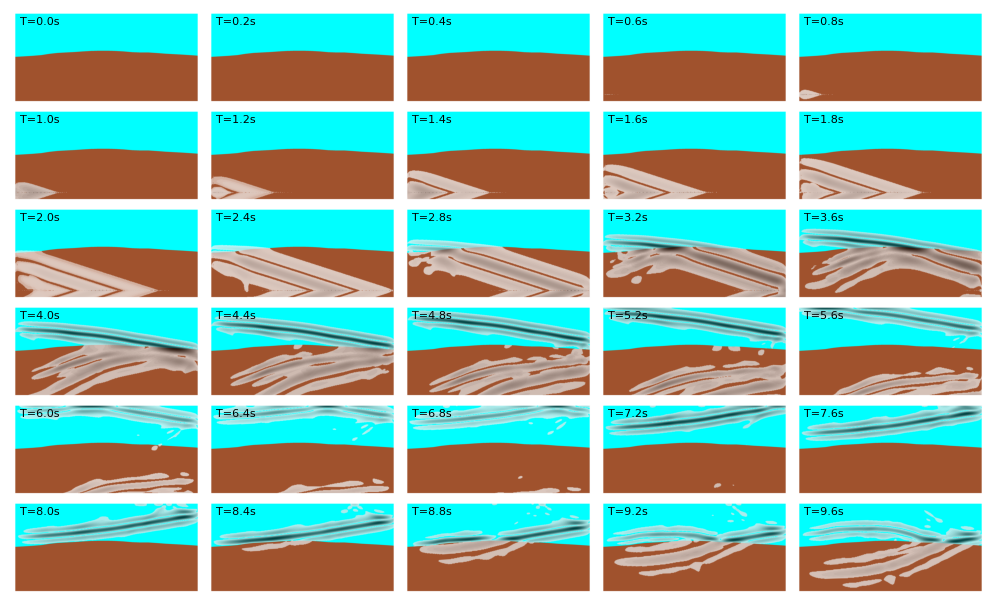

: 

In [ ]:
from specfempp.examples_utilities import plot
dt = config.get_par('simulation-setup.solver.time-marching.time-scheme.dt')
plot.plot_snapshots("OUTPUT_FILES/results", dt)

### Installation commands

Create conda environment
```bash
conda create -y --name pygmt --channel conda-forge pygmt obspy cartopy jupyter
```

Activate the environment
```bash
conda activate pygmt
```

Install C++ library using pip
```
export VTK_DIR=path/to/headless/vtk_build # not needed!
git clone git@github.com:PrincetonUniversity/SPECFEMPP.git
cd SPECFEMPP
pip install . --verbose -Ccmake.define.Kokkos_ENABLE_CUDA=ON -Ccmake.define.Kokkos_ARCH_AMPERE80=ON
cd -
```

Install Python wrapper library
```bash
git clone git@github.com:PrincetonUniversity/specfempp-py.git
cd specfempp-py
pip install -e .
```

### Run the notebook

```bash
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:path/to/headless_vtk_build/lib64/ # Not needed if building without VTK support
jupyter notebook [--no-browser]
```